In [1]:
import kdshmap as kd
import qutip as q
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import scipy as sp


* Driven transmon coupled to a near-resonant two-level system


In [2]:
## plot setup

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('axes', labelsize=15) 
matplotlib.rc('axes', labelsize=15) 

plt.rcParams["font.family"] = "Computer Modern Roman"
plt.rcParams.update({
    "text.usetex": True
})

# Example: Transmon & TLS

## Transmon Hamiltonian & TLS parameter

In [3]:
# Transmon parameters
tmon_dim = 2  # transmon truncation dimension
wq = 4 * 2*np.pi  # transmon frequency
alpha = -0.3 * 2*np.pi  # transmon anharmonicity

# Transmon Hamiltonian
Hq = q.num(tmon_dim)*wq + alpha * (q.num(tmon_dim)*(q.num(tmon_dim)-1)/2)
n_op = q.destroy(tmon_dim)+q.create(tmon_dim)

# A TLS as the noise source
wt = 3.85 * 2*np.pi
g = 0.005*2*np.pi
gamma = 0.05*2*np.pi
f_list = np.linspace(-10, 10, 2001)
Sf_list = gamma/((gamma/2)**2+(f_list-wt/2/np.pi)**2*4*np.pi**2) * g**2 ## Lorentzian spectrum describing the TLS


## Pulse shaping

### drive frequency negative detuning by 0.1

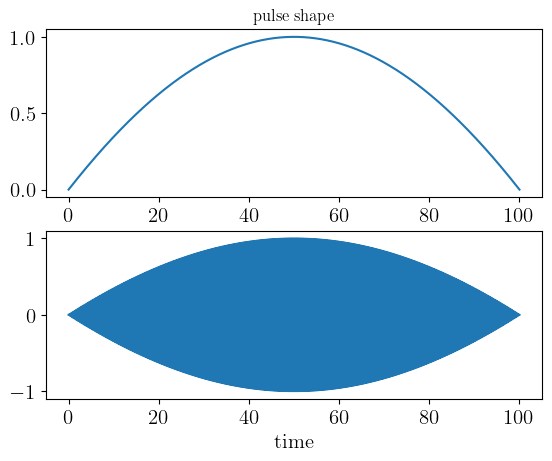

In [4]:
def gaussian_env(t_list, mid, duration, scale):
    
    env = sp.stats.norm(loc = mid, scale = scale).pdf(t_list)
    env_min = np.amin(env[np.where((t_list>mid-duration/2) & (t_list<mid+duration/2))])
    env = env - env_min
    env = np.fmax(env, np.zeros(env.shape))
    env = env/np.amax(env)

    return env


t_list = np.linspace(0, 100, 50001)
env = gaussian_env(t_list, t_list[-1]/2, t_list[-1], t_list[-1])
wd = wq - 0.13*2*np.pi
drive = np.cos(wd*t_list) * env


fig, ax = plt.subplots(2,1)
ax[0].plot(t_list, env)
ax[1].plot(t_list, drive)
ax[1].set_xlabel('time')
ax[0].set_title('pulse shape')

amp = np.pi/np.sum(env)/abs(t_list[1]-t_list[0]) * 8
drive = drive*amp

In [5]:
H = [Hq, [n_op, sp.interpolate.CubicSpline(t_list, drive)]]

## __kdshmap__ output

### Solver initialization

In [6]:
# kdshsolver
t_list_output = np.linspace(0, t_list[-1], 401)
minimal_step = 1/(wq/2/np.pi)/20
pure_state = q.basis(tmon_dim, 1)
measure_state = q.basis(tmon_dim, 1)
solver = kd.KeldyshSolver(H, t_list_output, minimal_step, [n_op],
                          [f_list], [Sf_list], trunc_freq=[(0, 5)], density0=pure_state*pure_state.dag(),
                          e_ops=[measure_state*measure_state.dag()], spd_renorm_method='trapz', goal='None')

(3.0, 5.0)

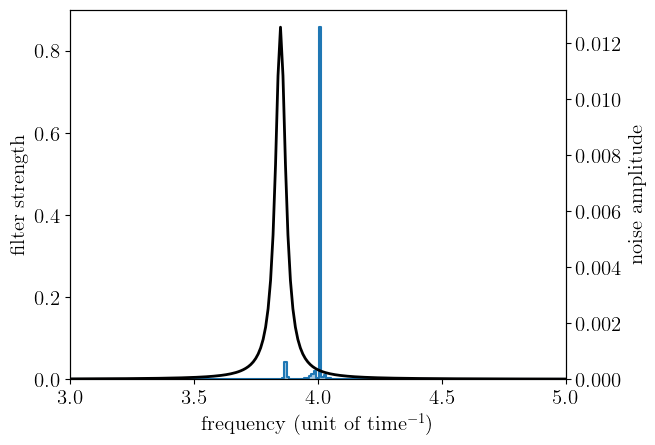

In [7]:
ax = solver.plot_filter_Sf()
ax.set_xlim(3,5)

Text(0, 0.5, 'purity')

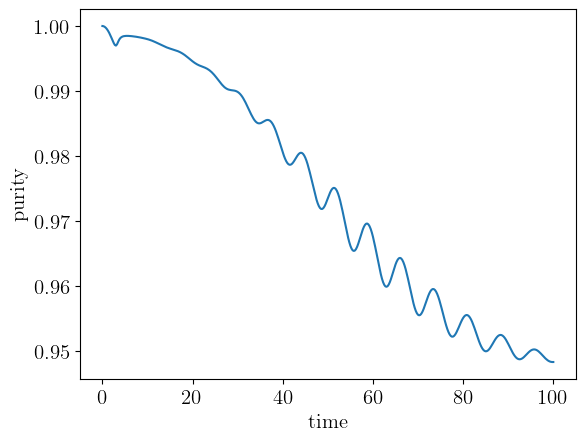

In [18]:
pure_state = (q.basis(tmon_dim, 1) + q.basis(tmon_dim, 0))/np.sqrt(2)
solver.density0 = pure_state * pure_state.dag()
densities = solver.generate_densities()
purity_list = np.einsum('ij,ij->i', densities, np.conjugate(densities))
plt.plot(solver.t_list_sub, abs(purity_list))
plt.xlabel('time')
plt.ylabel('purity')

Text(0, 0.5, 'process infidelity')

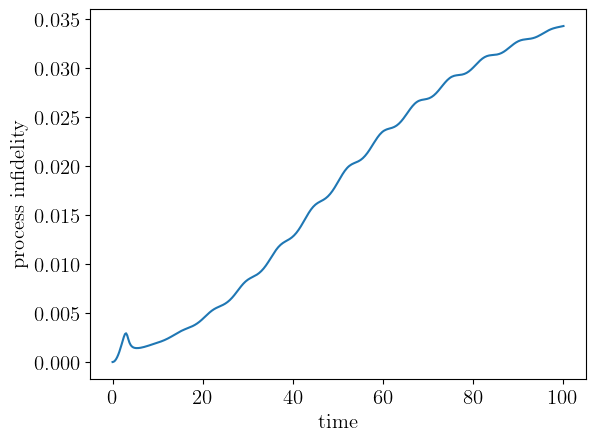

In [10]:
solver.generate_errors()
fig, ax = plt.subplots(1,1)

ax.plot(solver.t_list_sub, solver.error_list)
ax.set_xlabel('time')
ax.set_ylabel('process infidelity')

### Comparison: positive detuning 0.1

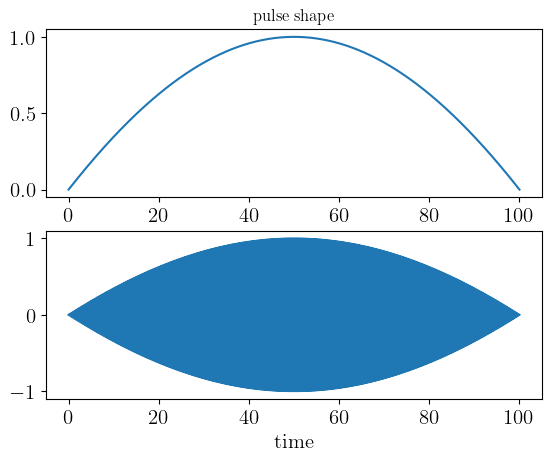

In [11]:
wd = wq + 0.13*2*np.pi
drive = np.cos(wd*t_list) * env

fig, ax = plt.subplots(2,1)
ax[0].plot(t_list, env)
ax[1].plot(t_list, drive)
ax[1].set_xlabel('time')
ax[0].set_title('pulse shape')

amp = np.pi/np.sum(env)/abs(t_list[1]-t_list[0]) * 8.0
drive = drive*amp
H = [Hq, [n_op, sp.interpolate.CubicSpline(t_list, drive)]]

In [12]:
# kdshsolver
t_list_output = np.linspace(0, t_list[-1], 401)
minimal_step = 1/(wq/2/np.pi)/20
pure_state = q.basis(tmon_dim, 1)

solver2 = kd.KeldyshSolver(H, t_list_output, minimal_step, [n_op],
                          [f_list], [Sf_list], trunc_freq=[(0, 5)], density0=pure_state*pure_state.dag(),
                          e_ops=[pure_state*pure_state.dag()], spd_renorm_method='trapz', goal='None')

(3.0, 5.0)

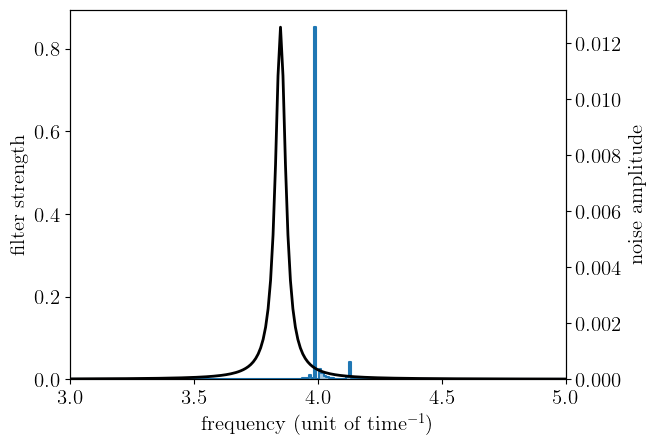

In [13]:
ax = solver2.plot_filter_Sf()
ax.set_xlim(3,5)

Text(0, 0.5, 'state purity')

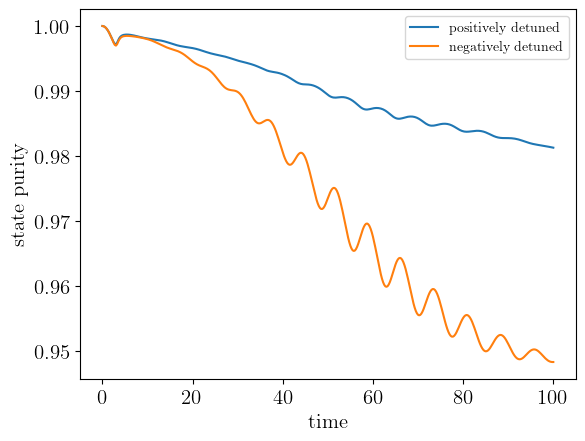

In [23]:
pure_state = (q.basis(tmon_dim, 1) + q.basis(tmon_dim, 0))/np.sqrt(2)
solver2.density0 = pure_state * pure_state.dag()
densities = solver2.generate_densities()
purity_list_2 = np.einsum('ij,ij->i', densities, np.conjugate(densities))
plt.plot(solver2.t_list_sub, abs(purity_list_2), label = 'positively detuned')
plt.plot(solver2.t_list_sub, abs(purity_list), label = 'negatively detuned')
plt.legend()
plt.xlabel('time')
plt.ylabel('state purity')

Text(0, 0.5, 'process infidelity')

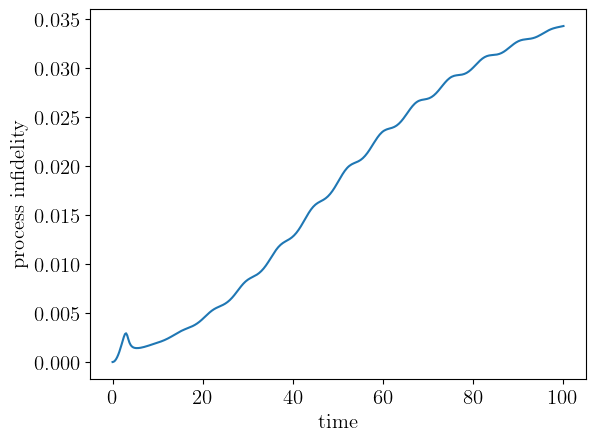

In [15]:
solver2.generate_errors()
fig, ax = plt.subplots(1,1)

ax.plot(solver2.t_list_sub, solver.error_list)
ax.set_xlabel('time')
ax.set_ylabel('process infidelity')